In [1]:
!pip install category_encoders

In [2]:
!pip install catboost

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import random
import os
import warnings
import easydict
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [5]:
train_df = train_df[train_df['price(원/kg)'] != 0]

# 함수 정의

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 시계열 특성 사용

In [7]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))

test_df['year'] = test_df['timestamp'].apply(lambda x : int(x[0:4]))
test_df['month'] = test_df['timestamp'].apply(lambda x : int(x[5:7]))
test_df['day'] = test_df['timestamp'].apply(lambda x : int(x[8:10]))

# 학습에 사용할 변수 정의

In [8]:
# 학습에 사용하지 않을 변수들을 제거
train_x = train_df.drop(columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)'])
train_y = train_df[['price(원/kg)']]

test_x = test_df.drop(columns=['ID', 'timestamp'])

test에는 supply(kg)이 없음

In [9]:
train_y

,price(원/kg)
2,1728.0
3,1408.0
4,1250.0
6,1474.0
7,1326.0
...,...
59392,468.0
59393,531.0
59394,574.0
59395,523.0


# 수치형 스케일링

In [10]:
no_category_cols = []
category_cols = ['corporation', 'location', 'year', 'month', 'day']

train_no_category = train_x[no_category_cols]
train_category = train_x[category_cols]

train_no_category.shape, train_category.shape

((23942, 0), (23942, 5))

In [11]:
no_category_cols = []
category_cols = ['corporation', 'location', 'year', 'month', 'day']

test_no_category = test_x[no_category_cols]
test_category = test_x[category_cols]

test_no_category.shape, test_category.shape

((1092, 0), (1092, 5))

In [33]:
'''# 스케일링 적용할 컬럼 선언
scaling_cols = ['supply(kg)']

# 수치형 데이터 프레임에서 스케일링 적용할 컬럼이 포함된 데이터 프레임 생성
train_scaling = train_no_category[scaling_cols]
#test_scaling = test_no_category[scaling_cols]

print(f'{train_scaling.shape}')# / {test_scaling.shape}')
train_scaling.head(3)'''

"# 스케일링 적용할 컬럼 선언\nscaling_cols = ['supply(kg)']\n\n# 수치형 데이터 프레임에서 스케일링 적용할 컬럼이 포함된 데이터 프레임 생성\ntrain_scaling = train_no_category[scaling_cols]\n#test_scaling = test_no_category[scaling_cols]\n\nprint(f'{train_scaling.shape}')# / {test_scaling.shape}')\ntrain_scaling.head(3)"

In [34]:
'''from sklearn.preprocessing import StandardScaler'''

'from sklearn.preprocessing import StandardScaler'

In [35]:
'''# 인스턴스 생성
std = StandardScaler()'''

'# 인스턴스 생성\nstd = StandardScaler()'

In [36]:
'''std.fit(train_scaling)'''

'std.fit(train_scaling)'

In [37]:
'''# 반영
X_train_scaled = std.transform(train_scaling)
X_test_scaled = std.transform(test_scaling)'''

'# 반영\nX_train_scaled = std.transform(train_scaling)\nX_test_scaled = std.transform(test_scaling)'

In [ ]:
'''X_train_scaled.shape, X_test_scaled.shape'''

In [ ]:
'''train_scaling.shape, test_scaling.shape'''

# 수치형, 범주형 합치기

In [12]:
_train_encoded = pd.DataFrame()
_test_encoded = pd.DataFrame()

for col in ['corporation', 'location', 'year', 'month', 'day']:
  _encoder = ce.OneHotEncoder(use_cat_names=True)
  _encoder.fit(train_category[col])
  _encoded = _encoder.transform(train_category[col])
  _train_encoded = pd.concat([_train_encoded, _encoded], axis=1)

  _encoded = _encoder.transform(test_category[col])
  _test_encoded = pd.concat([_test_encoded, _encoded], axis=1)

In [13]:
train_encoded = pd.concat([train_no_category, _train_encoded], axis=1)
train_encoded.shape

(23942, 11)

In [14]:
train_encoded

,corporation_A,corporation_B,corporation_C,corporation_D,corporation_E,corporation_F,location_J,location_S,year,month,day
2,1,0,0,0,0,0,1,0,2019,1,3
3,1,0,0,0,0,0,1,0,2019,1,4
4,1,0,0,0,0,0,1,0,2019,1,5
6,1,0,0,0,0,0,1,0,2019,1,7
7,1,0,0,0,0,0,1,0,2019,1,8
...,...,...,...,...,...,...,...,...,...,...,...
59392,0,0,0,0,0,1,1,0,2023,2,27
59393,0,0,0,0,0,1,1,0,2023,2,28
59394,0,0,0,0,0,1,1,0,2023,3,1
59395,0,0,0,0,0,1,1,0,2023,3,2


In [15]:
test_encoded = pd.concat([test_no_category, _test_encoded], axis=1)
test_encoded.shape

(1092, 11)

In [16]:
train_target = train_y
train_features = train_encoded

train_features.shape, train_target.shape

((23942, 11), (23942, 1))

# K-Fold

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

In [18]:
# 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

## DecisionTree

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
from sklearn.metrics import mean_squared_error

# ...

model = DecisionTreeClassifier(random_state=42)

n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # 학습
    model.fit(train_x, train_y)
    valid_pred = model.predict(valid_x)  # 예측값

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified Stratified K-Fold RMSE: 2385.230846143064
2 번째 Stratified Stratified K-Fold RMSE: 2437.5952840546092
3 번째 Stratified Stratified K-Fold RMSE: 2306.885964945636
4 번째 Stratified Stratified K-Fold RMSE: 2404.080644530291
5 번째 Stratified Stratified K-Fold RMSE: 2314.7675435563187
--------------------------------------------------
교차 검증 RMSE: 2369.712056645984


## XGBoost

### model 1

In [21]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [22]:
hp = {
    "random_state" : 42
}

model = XGBRegressor(**hp)
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1603.3417783520983
2 번째 Stratified K-Fold RMSE: 1652.0996569190856
3 번째 Stratified K-Fold RMSE: 1577.4587308520904
4 번째 Stratified K-Fold RMSE: 1630.441592577308
5 번째 Stratified K-Fold RMSE: 1558.2905633017106
--------------------------------------------------
교차 검증 RMSE: 1604.3264644004587


### model 2

In [23]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
model = XGBRegressor(**hp)

In [24]:
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,100, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

-1568.1648552984327

In [25]:
best_params = rs1.best_params_
best_params

{'n_estimators': 1042, 'max_depth': 5, 'learning_rate': 0.01}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

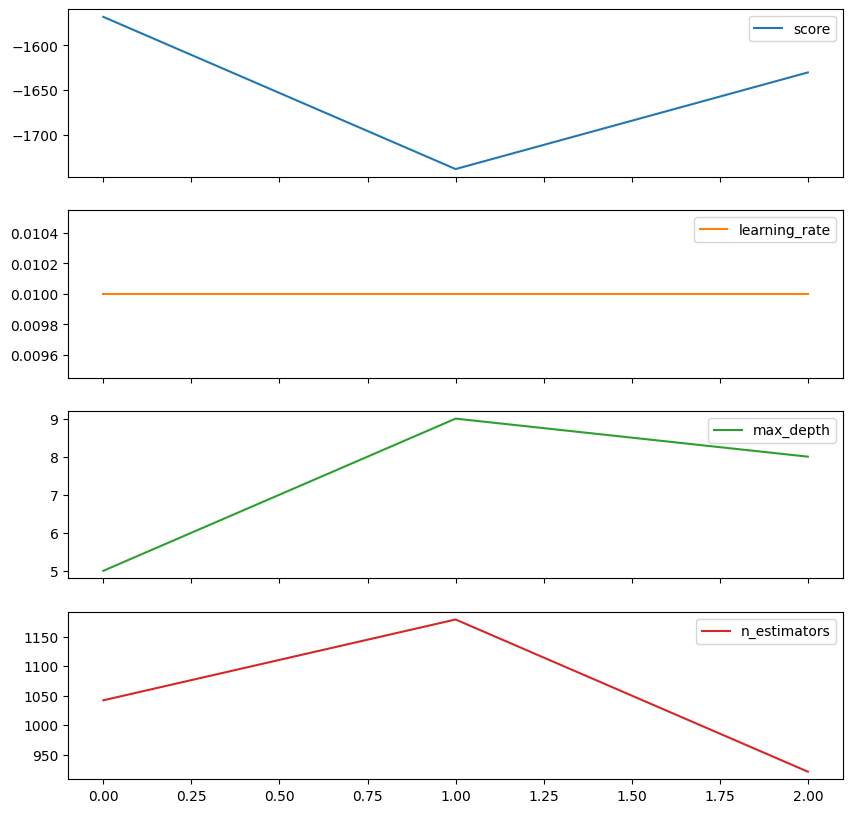

In [26]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [27]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [28]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
best_mode = XGBRegressor(**hp)

In [29]:
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1603.3417783520983
2 번째 Stratified K-Fold RMSE: 1652.0996569190856
3 번째 Stratified K-Fold RMSE: 1577.4587308520904
4 번째 Stratified K-Fold RMSE: 1630.441592577308
5 번째 Stratified K-Fold RMSE: 1558.2905633017106
--------------------------------------------------
교차 검증 RMSE: 1604.3264644004587


## Light GBM

### model 1

In [30]:
from lightgbm import LGBMRegressor, plot_importance

In [31]:
hp = {
    "random_state" : 42
}
model = LGBMRegressor(**hp)
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67
[LightGBM] [Info] Number of data points in the train set: 19153, number of used features: 11
[LightGBM] [Info] Start training from score 2807.026001
1 번째 Stratified K-Fold RMSE: 1538.263481001628
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67
[LightGBM] [Info] Number of data points in the train set: 19153, number of used features: 11
[LightGBM] [Info] Start training from score 2806.526079
2 번째 Stratified K-Fold RMSE: 1578.7455075108385
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing 

### model 2

In [32]:
hp = {
    "random_state" : 42,
    "verbose": -1, # 로그
}
model = LGBMRegressor(**hp)

In [33]:
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,100, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

-1561.4123991700822

In [34]:
best_params = rs1.best_params_
best_params

{'n_estimators': 1183, 'max_depth': 7, 'learning_rate': 0.01}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

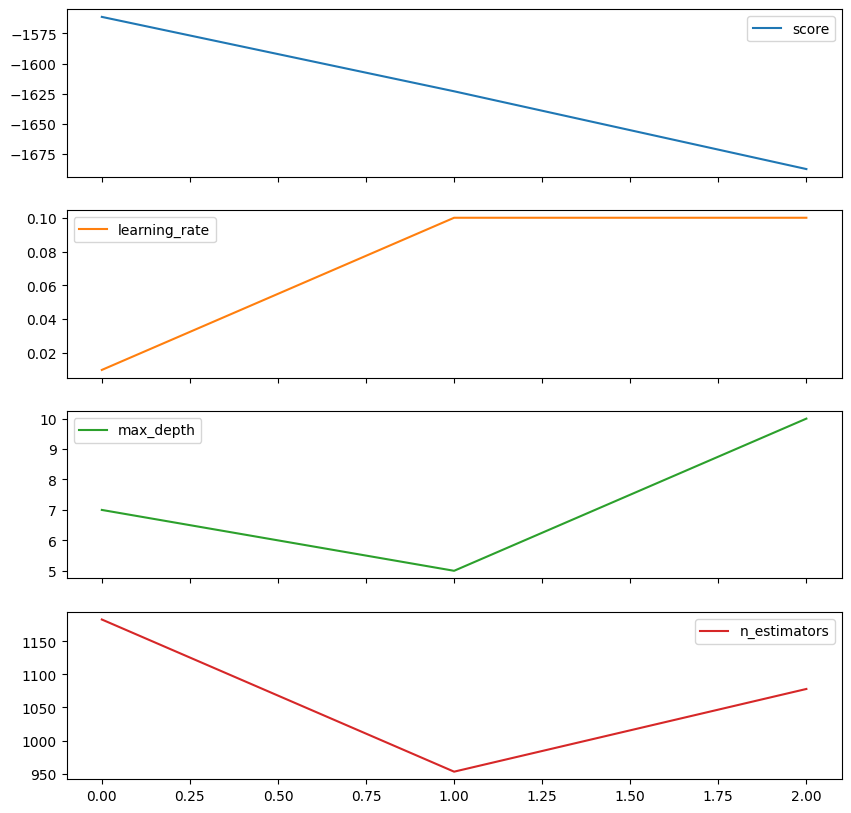

In [35]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [36]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [37]:
best_params['random_state'] = 42
best_params['verbose'] = -1

# best 모델 인스턴스 생성(정의)
best_mode = LGBMRegressor(**best_params)

In [38]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1538.263481001628
2 번째 Stratified K-Fold RMSE: 1578.7455075108385
3 번째 Stratified K-Fold RMSE: 1523.9480660011832
4 번째 Stratified K-Fold RMSE: 1565.847832383209
5 번째 Stratified K-Fold RMSE: 1499.173362526503
--------------------------------------------------
교차 검증 RMSE: 1562.2392547232675


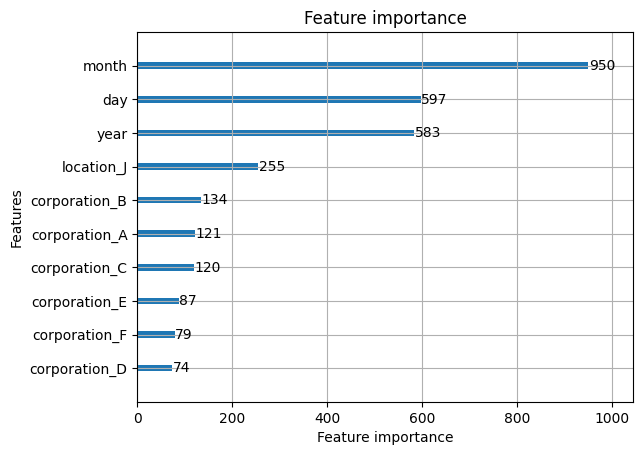

In [39]:
plot_importance(model)
plt.show()

## catboost

### model 1

In [40]:
from catboost import CatBoostRegressor

In [41]:
hp = {
    "random_state" : 42,
    "verbose" : 0 # 부스팅 단계 출력 안보이게 하기
}
model = CatBoostRegressor(**hp)
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1550.3275902983871
2 번째 Stratified K-Fold RMSE: 1597.863125392078
3 번째 Stratified K-Fold RMSE: 1530.716185878129
4 번째 Stratified K-Fold RMSE: 1582.4225987870218
5 번째 Stratified K-Fold RMSE: 1506.2051097243434
--------------------------------------------------
교차 검증 RMSE: 1560.0561715464487


### model 2

In [42]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
model = CatBoostRegressor(**hp)

In [43]:
n_iter=5 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(10,500,30, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

-1563.452224486768

In [44]:
best_params = rs1.best_params_
best_params

{'n_estimators': 280, 'max_depth': 12, 'learning_rate': 0.01}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

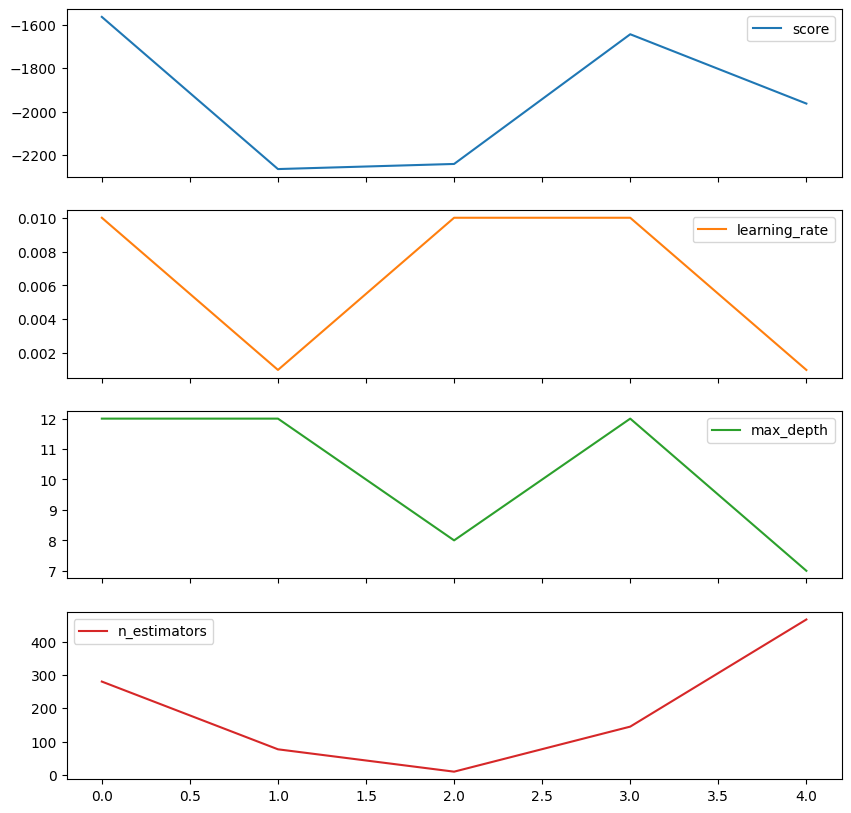

In [45]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [46]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [47]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
best_mode = CatBoostRegressor(**best_params)

In [48]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1550.3275902983871
2 번째 Stratified K-Fold RMSE: 1597.863125392078
3 번째 Stratified K-Fold RMSE: 1530.716185878129
4 번째 Stratified K-Fold RMSE: 1582.4225987870218
5 번째 Stratified K-Fold RMSE: 1506.2051097243434
--------------------------------------------------
교차 검증 RMSE: 1558.7463216403576


Text(0.5, 1.0, 'Feature Importance')

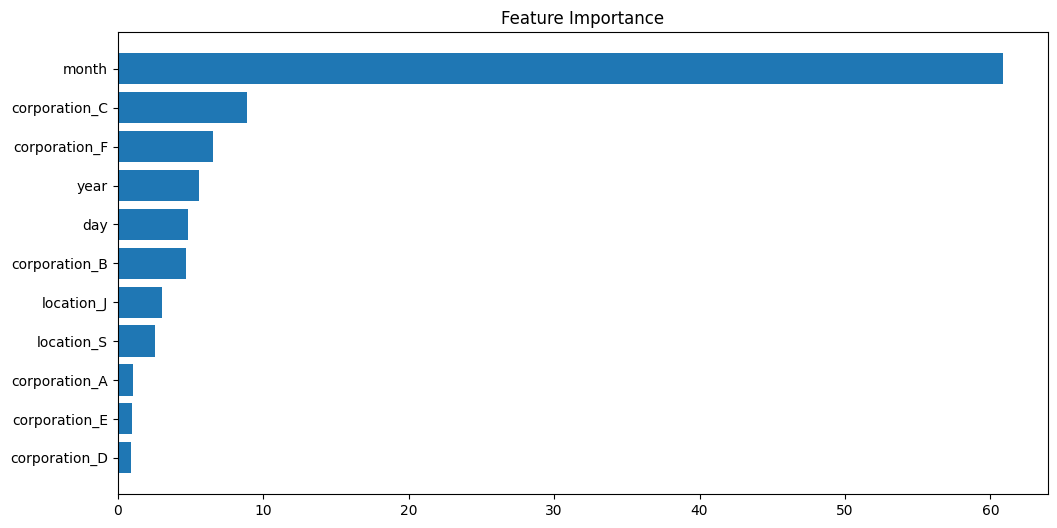

In [49]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(range(len(train_x)))[sorted_idx])
# 변수명이 있다면, 아래와 같이...
plt.yticks(range(len(sorted_idx)), np.array(train_x.columns)[sorted_idx])
plt.title('Feature Importance')

## 랜덤포레스트 (수정필요)

### model 1

In [133]:
#질적 변수들을 수치화합니다
qual_col = ['item', 'corporation', 'location']

for i in qual_col:
    le = LabelEncoder()
    train_x[i]=le.fit_transform(train_x[i])
    test_x[i]=le.transform(test_x[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다


model = RandomForestRegressor()
model.fit(train_x, train_y)

KeyError: ignored

In [ ]:
preds = model.predict(test_x)

RandomForestRegressor()

In [124]:
preds = model.predict(test_x)

CatBoostError: ignored

# train_y, pred RMSE

In [50]:
model

In [51]:
pred = model.predict(train_x)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))
print(f'RMSE: {rmse}')

RMSE: 1464.0896067313352


In [66]:
train_y

,price(원/kg)
3,1408.0
6,1474.0
8,1428.0
9,1433.0
10,1546.0
...,...
59389,388.0
59390,429.0
59393,531.0
59394,574.0


In [65]:
pred

array([1387.38021226, 1186.32771929, 1195.61683415, ...,  474.69201772,
        794.83470205,  665.4669374 ])

In [67]:
pred_df = pd.DataFrame(pred, columns=['price(원/kg)'])
pred_df

,price(원/kg)
0,1387.380212
1,1186.327719
2,1195.616834
3,1182.839972
4,1202.474473
...,...
19149,623.350660
19150,565.089190
19151,474.692018
19152,794.834702


# 학습 평가

## 산포도

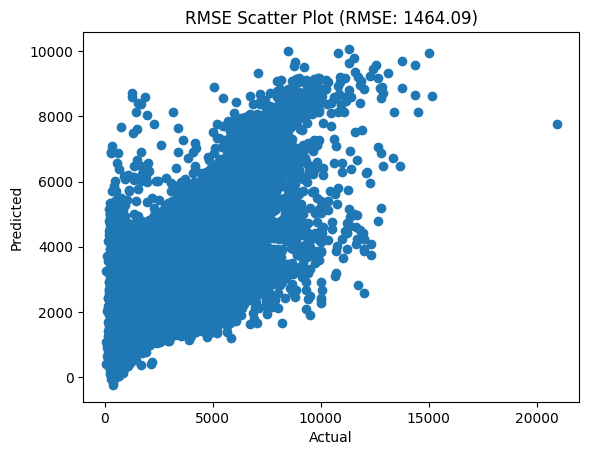

In [52]:
import matplotlib.pyplot as plt

# train_y와 pred의 RMSE를 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 산포도 그래프 생성
plt.scatter(train_y, pred)

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'RMSE Scatter Plot (RMSE: {rmse:.2f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# 그래프 표시
plt.show()

## 예측 오차 히스토그램

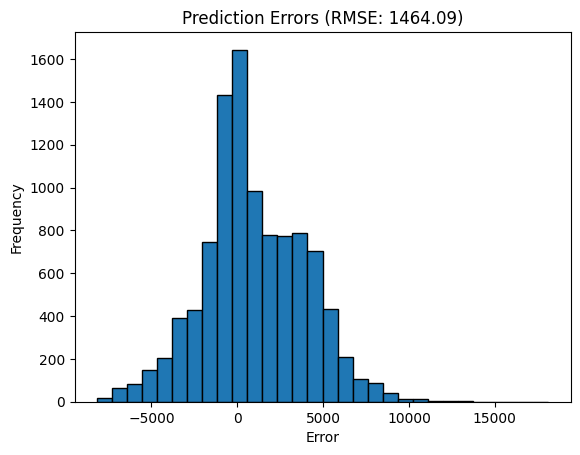

In [68]:
# 예측 오차 계산
errors = train_y - pred_df

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 히스토그램 생성
plt.hist(errors, bins=30, edgecolor='k')

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'Prediction Errors (RMSE: {rmse:.2f})')
plt.xlabel('Error')
plt.ylabel('Frequency')

# 그래프 표시
plt.show()

## 오차의 절대값 히스토그램

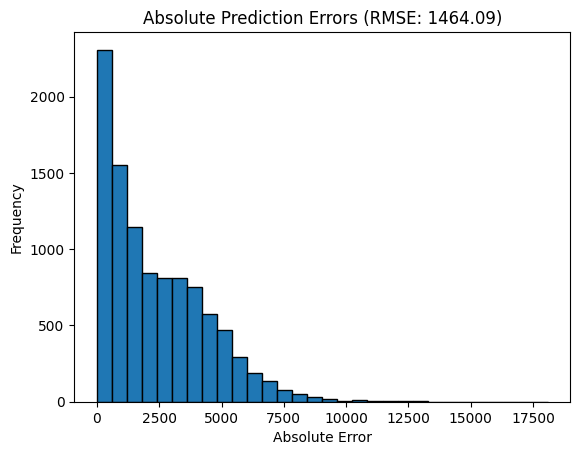

In [69]:
# 예측 오차 계산 (절대값)
errors = np.abs(train_y - pred_df)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 히스토그램 생성
plt.hist(errors, bins=30, edgecolor='k')

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'Absolute Prediction Errors (RMSE: {rmse:.2f})')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')

# 그래프 표시
plt.show()

## 상위 오차 샘플 확인

In [70]:
# 예측 오차 계산
errors = np.abs(train_y - pred_df)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 오차와 해당 오차가 속한 샘플의 인덱스를 결합하여 튜플로 만듭니다
error_samples = list(zip(errors, range(len(errors))))

# 오차를 기준으로 정렬합니다 (내림차순)
error_samples.sort(reverse=True, key=lambda x: x[0])

# 상위 N개의 오차 샘플을 확인합니다 (여기서는 상위 10개로 예시)
top_N = 10
top_errors = error_samples[:top_N]

# 결과 출력
for error, sample_idx in top_errors:
    print(f'Sample Index: {sample_idx}, Error: {error:.2f}, True Value: {train_y.iloc[sample_idx]:.2f}, Predicted Value: {pred[sample_idx]:.2f}')


ValueError: ignored

## Residual Plot

ValueError: ignored

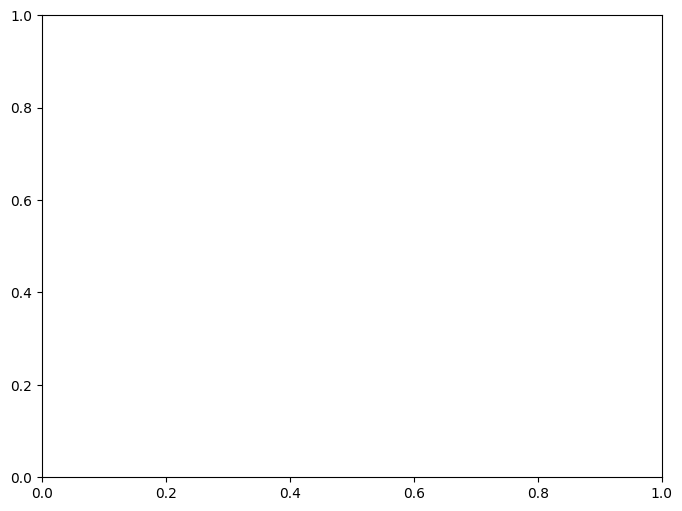

In [71]:
# 예측값과 실제값의 차이 (잔차) 계산
residuals = train_y - pred_df

# Residual Plot 그리기
plt.figure(figsize=(8, 6))
plt.scatter(pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Submission

In [61]:
submission = pd.read_csv('./sample_submission.csv')
submission

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [62]:
target_pred = model.predict(test_encoded)

In [63]:
submission['answer'] = target_pred
submission

,ID,answer
0,TG_A_J_20230304,2106.597494
1,TG_A_J_20230305,1999.621723
2,TG_A_J_20230306,1984.961693
3,TG_A_J_20230307,1950.651310
4,TG_A_J_20230308,1970.656186
...,...,...
1087,RD_F_J_20230327,1009.288009
1088,RD_F_J_20230328,816.623452
1089,RD_F_J_20230329,843.473068
1090,RD_F_J_20230330,790.727878


In [64]:
submission.to_csv('./baseline_submission.csv', index=False)